# Analyse data from vtu-files
*Date*: 2022-05-12,<br>
*Written by:* Johannes Borgqvist,<br>
Now we will try to load data from the FEM simulations of the RD model with FEniCS and see if we can analyse it. We will try to load the vtu-files into python, and then see if we can analyse the output data afterwards so to speak. 

### Import packages
Here, the main players are numpy for handling arrays etc., meshio for reading the data from the vtu-files, and DBSCAN from sklearn in order to do the clustering. 

In [1]:
import meshio # To extract the important parts of the mesh
import pandas as pd # Pandas for dataframes
import numpy as np # Import numpy as well
import Schnakenberg_properties # Home made
from matplotlib import pyplot as plt # Do the plotting using matplotlib
from mpl_toolkits.mplot3d import Axes3D # <--- This is important for 3d plotting 
from sklearn.cluster import DBSCAN # To calculate the number of poles in the concentration profile
import math as m # Mathematical functions
import matplotlib.font_manager as font_manager # For the font manager

### Functions for spherical coordinates

In [2]:
def cart2sph(x,y,z):
    XsqPlusYsq = x**2 + y**2
    r = m.sqrt(XsqPlusYsq + z**2)               # r
    elev = m.atan2(z,m.sqrt(XsqPlusYsq))     # theta
    az = m.atan2(y,x)                           # phi
    return r, elev, az

### Read the concentration profile from a vtu-file and plot it in Python
The aim of this section is to read the concentration profile from one of the vtu-files we have created through our simulations, and then plot it in Python. When we have read in the values into numpy-array, the goal is to be able to use k-means clustering to determine the number of poles we have in the concentration profile. 

Here, we study the Schnakenberg RD-model of pattern formation on the unit sphere:

\begin{align*}
\dfrac{\partial u}{\partial t}&=\gamma\left(a-u+u^2v\right)+\nabla^2 u,\\
\dfrac{\partial v}{\partial t}&=\gamma\left(b-u^2v\right)+d\nabla^2 v,
\end{align*}
for $t\geq 0,\;\mathbf{x}\in S^2$. Subsequently, we are also interested in adding holes to the unit sphere and see how this affects the pattern. 

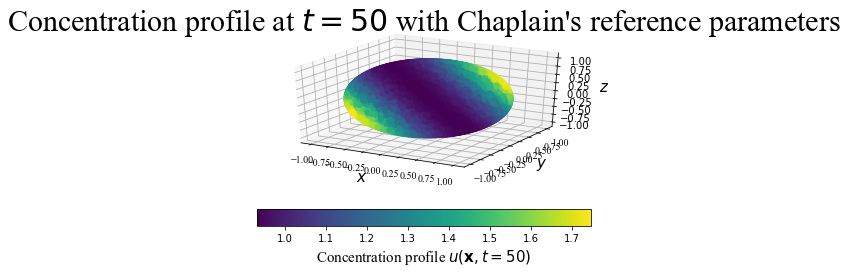

In [3]:
#----------------------------------------------------------------------------------
#----------------------------------------------------------------------------------
#----------------------------------------------------------------------------------
# Define the parameter pairs
#----------------------------------------------------------------------------------
#----------------------------------------------------------------------------------
#----------------------------------------------------------------------------------
# The parameters in the Schnakenberg model
a = 0.2
b = 1.0
# The wavenumber k^2
n = 2
k_squared = n*(n+1)
# Calculate the steady states and the critical parameters
u_0, v_0, d_c, gamma_c = Schnakenberg_properties.calculate_steady_states_and_critical_parameters_Schnakenberg(a,b,k_squared)
# Save the steady states in a list
steady_states = [u_0,v_0]
# Set the value of the relative diffusion
d = 18.0
# Set the value of the reaction strength to its critical value
gamma = gamma_c
# Define the number of holes
num_holes = 0
# Define the radius
radii_holes = []
# Define that we have the ICs around the steady states
ICs_around_steady_states = True
# Define the perturbation in the initial conditions
sigma = 1e-4
# Define the end time for the simulations
T = 50
# Let's start with the zeroth repitition
repitition_index = 0
#----------------------------------------------------------------------------------
#----------------------------------------------------------------------------------
#----------------------------------------------------------------------------------
# DEFINE THE FOLDERS WE LOOK THROUGH
#----------------------------------------------------------------------------------
#----------------------------------------------------------------------------------
#----------------------------------------------------------------------------------
folder_str = "../Output/"
a_str = "a_" + str(round(a,3)).replace(".","p") + "_"
b_str = "b_" + str(round(b,3)).replace(".","p") + "_"
d_str = "d_" + str(round(d,3)).replace(".","p") + "_"
gamma_str = "gamma_" + str(round(gamma,3)).replace(".","p") + "_"
sigma_str = "sigma_" + str(round(sigma,3)).replace(".","p") + "_"
T_str = "T_" + str(round(T,3)).replace(".","p") + "_"
if ICs_around_steady_states:
    IC_str = "ICs_around_steady_states/"
else:
    IC_str = "ICs_at_zero/"
# Define the radius and the hole string
hole_str = "h_0_"
# Radius string
radius_str = ""
# Gather all these substrings into one giant string where we will save the output files
mesh_name = folder_str + hole_str + radius_str + a_str + b_str + d_str + gamma_str + sigma_str + T_str + IC_str + "iteration_" + str(repitition_index) + "/u000101"
#----------------------------------------------------------------------------------
#----------------------------------------------------------------------------------
#----------------------------------------------------------------------------------
# Read the concentration profile and spatial coordinates
#----------------------------------------------------------------------------------
#----------------------------------------------------------------------------------
#----------------------------------------------------------------------------------
# Read the msh file
conc_profile = meshio.read(mesh_name + ".vtu")
# Extract the concentration profile
u = np.asarray(list(conc_profile.point_data.values())[0])
# Extract the spatial coordinates
spatial_coordinates = conc_profile.points
# Save each of the coordinates as numpy arrays (i.e. we get three arrays named x, y and z)
x = np.asarray([spatial_coordinates[index][0] for index in range(len(spatial_coordinates))])
y = np.asarray([spatial_coordinates[index][1] for index in range(len(spatial_coordinates))])
z = np.asarray([spatial_coordinates[index][2] for index in range(len(spatial_coordinates))])
#----------------------------------------------------------------------------------
#----------------------------------------------------------------------------------
#----------------------------------------------------------------------------------
# Plot the concentration profile using matplotlib
#----------------------------------------------------------------------------------
#----------------------------------------------------------------------------------
#----------------------------------------------------------------------------------
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
img = ax.scatter(x, y, z, c=u, cmap='viridis', alpha=1)
cb = plt.colorbar(img, orientation="horizontal")
cb.set_label(label='Concentration profile $u(\mathbf{x},t=50)$',fontname="Times New Roman", size=15)
# changing the fontsize of yticks
plt.xticks(fontname="Times New Roman", size=10)
plt.yticks(fontname="Times New Roman", size=10)
ax.set_xlabel('$x$',fontname="Times New Roman", size=15)
ax.set_ylabel('$y$',fontname="Times New Roman", size=15)
ax.set_zlabel('$z$',fontname="Times New Roman", size=15)
ax.set_title('Concentration profile at $t=50$ with Chaplain\'s reference parameters',fontname="Times New Roman", size=30,fontweight="bold")
plt.show()

## Density based clustering of the number of poles using DBSCAN 
So the clustering is done in two step! First, we save all spatial coordinates that are above a certain threshold value. In this case we will set the threshold value to 80% of the maximum value of u. Then, we have a bunch of spatial coordinates, and then we can cluster them based on spatial proximity. Density based clustering is particularly efficient when it comes to [clustering spatial data](https://geoffboeing.com/2014/08/clustering-to-reduce-spatial-data-set-size/). 

In [4]:
# Define a threshold concentration
threshold_concentration = 0.8*max(u)
# Save the spatial coordinates for which the concentration profile is above our threshold value
spatial_coordinates = np.asarray([[x[index], y[index], z[index]] for index in range(len(u)) if u[index]>=threshold_concentration])
# CLUSTERING: conduct the density based scan using DBSCAN
epsilon = 1
db = DBSCAN(eps=epsilon, min_samples=1).fit(spatial_coordinates)
cluster_labels = db.labels_
# Get the number of poles
num_poles = len(set(cluster_labels))
print("The number of poles is:\t\t\t%d,"%(num_poles))
relative_pole_area = 100*len(spatial_coordinates)/len(u)
print("The relative pole area:\t\t\t%2.2f%%,"%(relative_pole_area))
pole_area_1 = 100*(len([label for label in cluster_labels if label==0])/len(u))
pole_area_2 = 100*(len([label for label in cluster_labels if label==1])/len(u))
print("The relative pole area of pole 1:\t%2.2f%%,"%(pole_area_1))
print("The relative pole area of pole 2:\t%2.2f%%."%(pole_area_2))

The number of poles is:			2,
The relative pole area:			23.99%,
The relative pole area of pole 1:	12.01%,
The relative pole area of pole 2:	11.98%.


# Visualising the poles in spherical coordinates
Imagine that we have spherical coordinates:
\begin{align*}
x&=r\cos(\theta)\sin(\phi)\\
y&=r\cos(\theta)\sin(\phi)\\
z&=r\cos(\phi)\\
\end{align*}
where we work on the unit sphere with $r=1$. Would it be a nice idea to represent the poles as well as the hole in the $(\theta,\phi)$-plane?

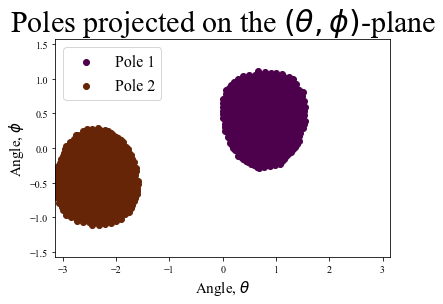

In [5]:
# Extract the coordinates belong to pole 1
pole_1_coordinates = np.asarray([spatial_coordinates[index] for index,label in enumerate(cluster_labels) if label==0])
# Covert to spherical coordinates
pole_1_spherical = np.asarray([list(cart2sph(coordinate[0],coordinate[1],coordinate[2])) for coordinate in pole_1_coordinates])
# Extract the coordinates belong to pole 2
pole_2_coordinates = np.asarray([spatial_coordinates[index] for index,label in enumerate(cluster_labels) if label==1])
# Covert to spherical coordinates
pole_2_spherical = np.asarray([list(cart2sph(coordinate[0],coordinate[1],coordinate[2])) for coordinate in pole_2_coordinates])
#----------------------------------------------------------------------------------
#----------------------------------------------------------------------------------
#----------------------------------------------------------------------------------
# Plot the concentration profile using matplotlib
#----------------------------------------------------------------------------------
#----------------------------------------------------------------------------------
#----------------------------------------------------------------------------------
fig = plt.figure()
ax = fig.add_subplot(111)
# Pole 1
plt.scatter(pole_1_spherical[0][2], pole_1_spherical[0][1], marker='o',color=(77/256,0/256,75/256),label='Pole 1')
for index in range(1,len(pole_1_spherical)):
    plt.scatter(pole_1_spherical[index][2], pole_1_spherical[index][1], marker='o',color=(77/256,0/256,75/256))
# Pole 2
plt.scatter(pole_2_spherical[0][2], pole_2_spherical[0][1], marker='o',color=(102/256,37/256,6/256),label='Pole 2')
for index in range(1,len(pole_2_spherical)):
    plt.scatter(pole_2_spherical[index][2], pole_2_spherical[index][1], marker='o',color=(102/256,37/256,6/256))
font = font_manager.FontProperties(family="Times New Roman",
                                   weight="bold",
                                   style="normal", size=16)
plt.legend(prop=font)    
# changing the fontsize of yticks
plt.xticks(fontname="Times New Roman", size=10)
plt.yticks(fontname="Times New Roman", size=10)
plt.xlim(-np.pi, np.pi)
plt.ylim(-np.pi/2, np.pi/2)
ax.set_xlabel('Angle, $\\theta$',fontname="Times New Roman", size=15)
ax.set_ylabel('Angle, $\\phi$',fontname="Times New Roman", size=15)
ax.set_title('Poles projected on the $(\\theta,\\phi)$-plane',fontname="Times New Roman", size=30,fontweight="bold")
plt.show()